# Disease propagation in a network

Goals for today:

* Do the homework from last class:
    * Think about the other degree distribution
    * Write the other network builder, compare
    * Turn ntwork builders into functions (or methods?)
* The idea of SIR model ([link](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology))
* Implement a simple model (SI)
* Think of our computational experiment (hyperparameters, what to sweep what to fix, output)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A graph of 2 nodes:
0:[1]
1:[0]

Nodes: [0, 1]
Edges: [(0, 1)]


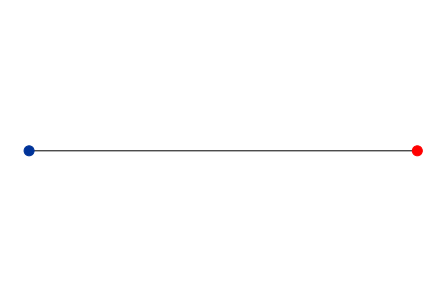

In [54]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.values = {}
        
    def add_node(self, node, val=0):
        """If node is not in a dictionary, add it."""
        if node not in self.gdict:
            self.gdict[node] = []
        self.values[node] = val
    
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
        # Add node2 as a connection for node1, and the other way around
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def get_nodes(self):
        """Returns a list of nodes."""
        return list(self.gdict.keys())
    
    def get_edges(self):
        """Returns a list of edges."""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
            
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1,0,0)
        BLUE = (0,0.2,0.6)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.values[nodes[i]]==0:
                colors.append(BLUE)
            else:
                colors.append(RED)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
    
# Test
g = Graph()
g.add_edge(0,1)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.values[0] = 1
g.plot()

In [40]:
def degrees(g):
    """Calculates and plots the degrees distribution for a graph."""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    #print(degrees)
    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    #print(hist)

    plt.plot(hist,'.-');
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    
    return hist

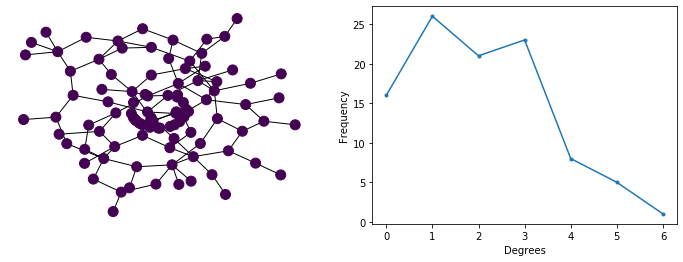

In [50]:
"""Let's screate a random network."""
def random_network(n_nodes=7):
    n_edges = n_nodes

    g = Graph()
    for i in range(n_nodes):
        g.add_node(i)
    edges = []
    while len(edges)<n_edges:
        n1 = np.random.randint(low=0, high=n_nodes)
        n2 = np.random.randint(low=0, high=n_nodes)
        if n2<n1:
            n1,n2 = n2,n1

        if (n1,n2) not in edges and n1!=n2:
            g.add_edge(n1,n2)
            edges.append((n1,n2))
    return g
    
#print(g)

g = random_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees_random = degrees(g)

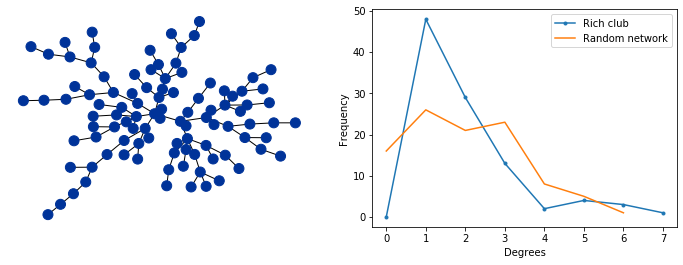

In [56]:
# Alternative network creator
def rich_club_network(n_nodes=7):
    g = Graph()
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        else:
            g.add_edge(i, np.random.randint(low=0, high=i))
    return g

g = rich_club_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g)
plt.plot(degrees_random);
plt.legend(['Rich club','Random network']);

* A loop over time (for a certain number of steps):
    * For each node that is "sick" (infectious):
        * For all healthy nodes that are connected to this sick node:
            * Roll the dice. Wit some probability, infect this neighboring node

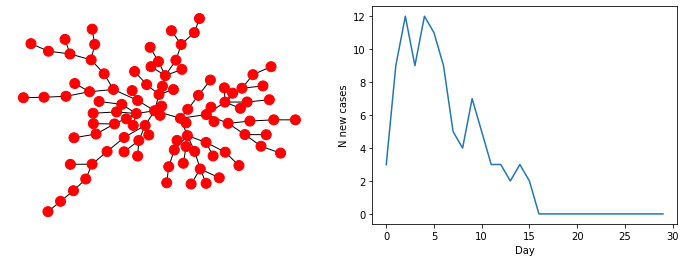

In [125]:
def pandemic(g, prob=0.5, nsteps=10):
    """Runs the pandemic for several steps."""
    for node in g.get_nodes():
        g.values[node] = 0      # First set all nodes to healthy 
    g.values[0] = 1             # Only node 0 is sick

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        for node in g.get_nodes():
            if g.values[node]==1:
                neighbors = g.gdict[node]
                for neighbor in neighbors:
                    if g.values[neighbor]==0 and np.random.uniform()<prob:
                        newly_infected.append(neighbor)
        for node in newly_infected:
            g.values[node] = 1
        history[t] = len(newly_infected)
    return history

history = pandemic(g, prob=0.5, nsteps=30)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
plt.plot(history);
plt.xlabel('Day');
plt.ylabel('N new cases');

### Homework:

* When running pandemic, don't always infect the same node #0, but pick the patient 0 at random, among all nodes in the network.
* Make a guess (for yourself), which type of a network (of 2 that we have so far) will be more prone to pandemic.
* Compare two network configurations. Run the pandemic on both of them, and compare the plots of new cases. For now, keep everything else the same (the number of nodes, edges, probability of contagion).
* Add a loop and averaging to run several experiments for both network types. Meaning: for each network type, generate N different networks, and run a pandemics on each of them. Remember the curves, average the curves, and plot these smoothed averages.
